In [1]:
KERAS_MODELS_ABSOLUTE_PATH = '/content/gdrive/My Drive/3ecnn13'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install -qq tensorflow-datasets -U
!tfds --version

TensorFlow Datasets: 4.4.0


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
plt.rc('figure', figsize=(13, 4))

2.7.0


In [5]:
if not tf.io.gfile.exists(KERAS_MODELS_ABSOLUTE_PATH):
  print('You should create', KERAS_MODELS_ABSOLUTE_PATH, 'directory manually')
  assert False

In [6]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.9.156.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.156.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [7]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [8]:
def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

In [9]:
def build_model(name, in_shape, activation, pooling, out_shape, *in_steps):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs, outputs = [], []
  streaming = in_shape[0] == 1

  x = x_in = keras.Input(shape=in_shape)

  for i in in_steps:
    x = keras.layers.Conv1D(i, 1, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.SpatialDropout1D(i / 1280.0)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 1 + 2**i, inputs, outputs, x)
    x = keras.layers.Conv1D(x.shape[-1], 2,
                            dilation_rate=2**i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.SpatialDropout1D(x.shape[-1] / 1280.0)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = pooling(x.shape[1])(x)
  x = keras.layers.Flatten()(x)

  for i in x.shape[-1] * np.array([2, 1]):
    x = keras.layers.Dense(i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.Dropout(i / 1280.0)(x)

  x = keras.layers.Dense(out_shape)(x)
  return keras.Model([x_in] + inputs, [x] + outputs, name=name)

In [10]:
def build_ensemble(name='second_ensemble', builders=None,
                   models=None, activation=None, streaming=False):
  in_shape = (1 if streaming else 47, 13)
  if models:
    x_in = keras.Input(shape=in_shape)
    x = [keras.Model(m.inputs, m.outputs) for m in models]
    if streaming:
      inputs = [[keras.Input(e.shape[1:]) for e in m.inputs[1:]] for m in x]
      x = [e([x_in] + i) for e, i in zip(x, inputs)]
      inputs = [i for e in inputs for i in e]
      outputs = [i for e in x for i in e[1:]]
      x = [e[0] for e in x]
    else:
      inputs, outputs = [], []
      x = [e(x_in) for e in x]
    if activation:
      x = [keras.layers.Activation(activation)(e) for e in x]
      x = keras.layers.Average()(x)
    else:
      b, c = x
      b = tf.squeeze(b, -1)
      b = tf.greater(b, 2) # threshold
      u = tf.greater(c[:,10], c[:,11])
      u = tf.where(u, 10, 11)
      x = tf.where(b, tf.argmax(c, -1, u.dtype), u)
      x = tf.one_hot(x, 12)
    return keras.Model([x_in] + inputs, [x] + outputs)
  else:
    return tuple(b(name, in_shape, *a) for b, *a in builders)

In [11]:
models_builders_bin = (
  (build_model, 'leaky_relu', keras.layers.MaxPool1D, 1,     128),
  (build_model, 'relu',       keras.layers.AvgPool1D, 1,     128),
  (build_model, 'relu6',      keras.layers.MaxPool1D, 1, 64, 128),
  (build_model, 'elu',        keras.layers.AvgPool1D, 1, 64, 128),
)
models_bin_1 = build_ensemble(builders=models_builders_bin)
models_bin_2 = build_ensemble('third_ensemble', models_builders_bin)

In [12]:
def train_model(model, loss, train_dataset, valid_dataset):

  with strategy.scope():
    tpu_model = keras.Model.from_config(model.get_config())
    tpu_model.compile(
      loss=loss(from_logits=True),
      optimizer=keras.optimizers.Adam(),
      metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

  tpu_num_cores = resolver.get_tpu_system_metadata().num_cores

  train_batch = train_dataset.shuffle(train_dataset.cardinality())
  train_batch = train_batch.batch(tpu_num_cores * 64, drop_remainder=True)
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 1, 3, 5), y))
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
  train_batch = train_batch.prefetch(tf.data.AUTOTUNE)

  valid_batch = valid_dataset.batch(8, drop_remainder=True)
  valid_batch = valid_batch.prefetch(tf.data.AUTOTUNE)

  # plt.imshow(list(train_batch.take(1))[0][0][0].numpy().T)
  # plt.show()

  history = tpu_model.fit(train_batch,
                          validation_data=valid_batch,
                          callbacks=[early_stopping],
                          verbose=2,
                          epochs=1000) # play with google colab time limit

  model.set_weights(early_stopping.best_weights)
  return history

In [13]:
def train_ensemble(ensemble_models, loss, train_dataset, valid_dataset):

  for model in ensemble_models:
    md5 = str(model.get_config())
    md5 = !echo "$md5" | md5sum
    md5 = md5[0].split()[0]
    weights_file = "%s/%s.h5" % (KERAS_MODELS_ABSOLUTE_PATH, md5)

    if tf.io.gfile.exists(weights_file):
      print('Restoring model weights from', md5)
      model.load_weights(weights_file)
    else:
      history = train_model(model, loss, train_dataset, valid_dataset)
      model.save_weights(weights_file)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Valid'], loc='upper right')
      plt.show() 

In [14]:
def evaluate_ensemble(models, test_dataset, valid_dataset):
  history = []
  for model in models:
    o = model.output_shape[-1]   
    d = lambda x: np.argmax(x, -1) if o > 1 else x.squeeze(-1) > 0
    pred = d(model.predict(test_dataset.batch(512)))
    history.append(np.sum(pred != list(test_dataset.map(lambda x, y: y))))
    pred = d(model.predict(valid_dataset.batch(512)))
    history.append(np.sum(pred != list(valid_dataset.map(lambda x, y: y))))
  plt.xlim(-0.6, len(history)/2 - 0.4)
  plt.bar(np.arange(len(history)/2) - 0.2, history[::2], 0.4)
  plt.bar(np.arange(len(history)/2) + 0.2, history[1::2], 0.4)
  return np.array(history).reshape(-1, 2).tolist()

In [15]:
(train_dataset, test_dataset, valid_dataset), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-musan-1.appspot.com',
    as_supervised=True, try_gcs=True, with_info=True)
assert info.homepage == 'https://github.com/42io/dataset/tree/master/openslr_musan'
train_dataset.cardinality().numpy()

1825800

In [16]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y))
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y))
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y))

In [17]:
train_ensemble(models_bin_1, keras.losses.BinaryCrossentropy,
               train_dataset, valid_dataset)

Restoring model weights from 28323f803767caeb2261fa7304685acc
Restoring model weights from 3a120eaa0ec426481f89827dfc4a2782
Restoring model weights from f6540761d812702d3bb4466310e20b93
Restoring model weights from 4b4319045000911ff374050fa7882570


In [18]:
bin_ens = build_ensemble(models=models_bin_1, activation='linear')

[[15, 12], [17, 10], [17, 10], [14, 7], [11, 9]]

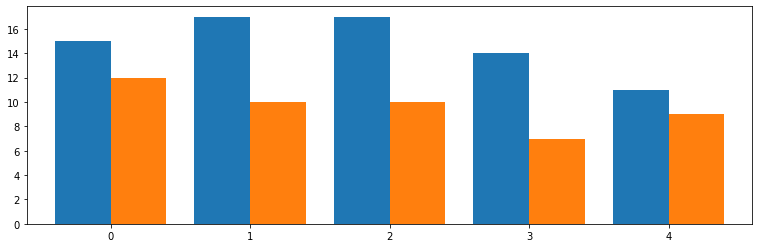

In [19]:
evaluate_ensemble(models_bin_1 + (bin_ens,), test_dataset, valid_dataset)

In [20]:
(train_dataset, test_dataset, valid_dataset), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-libri-1.appspot.com',
    as_supervised=True, try_gcs=True, with_info=True)
assert info.homepage == 'https://github.com/42io/dataset/tree/master/openslr_libri'
train_dataset.cardinality().numpy()

1825800

In [21]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y))
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y))
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y))

In [22]:
train_ensemble(models_bin_2, keras.losses.BinaryCrossentropy,
               train_dataset, valid_dataset)

Restoring model weights from 4b65b86fea1e055801112be26e5f0b56
Restoring model weights from fff40393ef87e68fa02c4cfd150f963e
Restoring model weights from 79a5564878f3fabe69c4efd2471c5211
Restoring model weights from 2743c293aaab27294d461206e5b2b0da


In [23]:
bin_ens = build_ensemble(models=models_bin_2, activation='linear')

[[26, 18], [26, 14], [20, 16], [28, 17], [22, 15]]

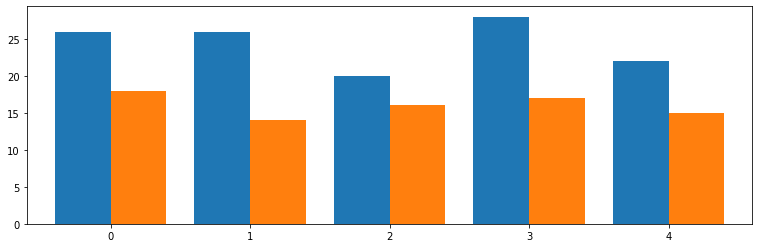

In [24]:
evaluate_ensemble(models_bin_2 + (bin_ens,), test_dataset, valid_dataset)

In [25]:
(train_dataset, test_dataset, valid_dataset), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-gsc-1.appspot.com',
    as_supervised=True, try_gcs=True, with_info=True)
assert info.homepage == 'https://github.com/42io/dataset/tree/master/google_speech_commands'
train_dataset.cardinality().numpy()

1095480

In [26]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y))
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y))
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y))

In [27]:
bin_ens = build_ensemble(models=models_bin_1 + models_bin_2, activation='linear')

[[312, 303],
 [299, 287],
 [316, 295],
 [315, 298],
 [285, 271],
 [273, 245],
 [265, 246],
 [307, 278],
 [289, 278]]

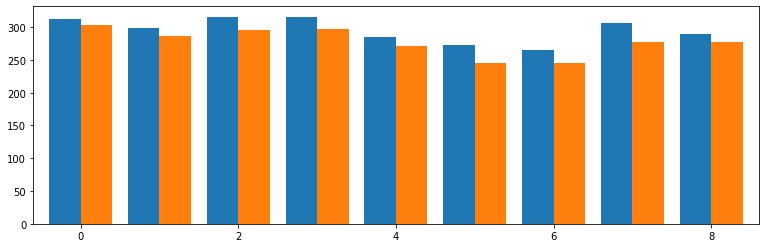

In [28]:
evaluate_ensemble(models_bin_1 + models_bin_2 + (bin_ens,),
                  test_dataset.map(lambda x, y: [x, y < 10]),
                  valid_dataset.map(lambda x, y: [x, y < 10]))

In [29]:
models_builders_cat = (
  (build_model, 'leaky_relu', keras.layers.MaxPool1D, 12,     128),
  (build_model, 'relu',       keras.layers.AvgPool1D, 12,     128),
  (build_model, 'relu6',      keras.layers.MaxPool1D, 12, 64, 128),
  (build_model, 'elu',        keras.layers.AvgPool1D, 12, 64, 128),
)
models_cat = build_ensemble(builders=models_builders_cat)

In [30]:
train_ensemble(models_cat, keras.losses.SparseCategoricalCrossentropy,
               train_dataset, valid_dataset)

Restoring model weights from e7e8bec4019f75b50021d0976ccd6c38
Restoring model weights from 77ea91aa526708b463ab0a466befa487
Restoring model weights from b86d75d1480db917ab133cc6027564c0
Restoring model weights from 76ae1b4ae2ff082f3154066d5e36578e


In [31]:
cat_ens = build_ensemble(models=models_cat, activation='softmax')

In [32]:
ens = build_ensemble(models=[bin_ens, cat_ens])
ens.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 47, 13)]     0           []                               
                                                                                                  
 model_6 (Functional)           (None, 12)           830896      ['input_3[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 1)            1650440     ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['model_6[0][0]']                
 ingOpLambda)                                                                               

[[45, 27], [48, 27], [51, 23], [42, 30], [40, 27], [55, 33]]

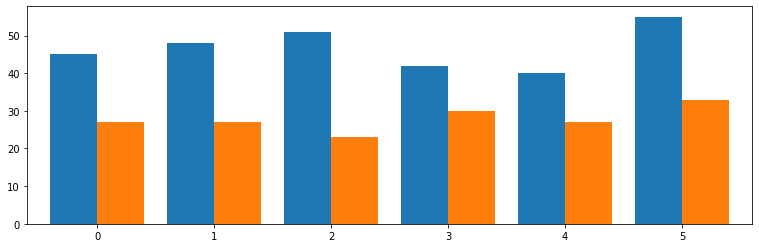

In [33]:
evaluate_ensemble(models_cat + (cat_ens, ens,),
                  test_dataset, valid_dataset)

In [34]:
matrix = tf.math.confusion_matrix(
  list(test_dataset.map(lambda x, y: y)),
  ens.predict(test_dataset.batch(4096)).argmax(axis=-1)).numpy()
for r in matrix:
  l = np.sum(r)
  for i in r:
    print(('%.2f' % (i / l)).replace('0.00', ' .  '), end = ' ')
  print("|", l)

0.99  .    .    .    .    .    .   0.01  .    .    .    .   | 315
 .   0.97  .    .    .    .    .    .    .   0.01 0.01  .   | 309
 .    .   0.99  .    .    .    .    .    .    .   0.01  .   | 304
 .    .    .   0.98  .    .    .    .    .    .   0.02  .   | 304
 .    .    .    .   0.99  .    .    .    .    .   0.01  .   | 310
 .    .    .    .    .   0.98  .    .    .    .   0.01  .   | 336
 .    .    .    .    .    .   0.99  .    .    .    .    .   | 249
 .    .    .    .    .    .    .   1.00  .    .    .    .   | 306
 .    .    .    .    .    .    .    .   0.99  .   0.01  .   | 298
 .    .    .    .    .   0.01  .    .    .   0.98 0.01  .   | 312
 .   0.01  .   0.01 0.01  .    .    .    .    .   0.97  .   | 365
 .    .    .    .    .    .    .    .    .    .    .   1.00 | 365


In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(ens)
tflite_model = converter.convert()
with open("_3ecnn47.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp83fxtjih/assets


INFO:tensorflow:Assets written to: /tmp/tmp83fxtjih/assets


In [36]:
!md5sum '_3ecnn47.tflite'
!mv '_3ecnn47.tflite' "$KERAS_MODELS_ABSOLUTE_PATH"

abd1f8c35fcdedf08d2ed662e4066afd  _3ecnn47.tflite


In [37]:
def transfer_weights(dest, src):
  for dest, src in zip(dest, src):
    for layer in dest.layers:
      if layer.get_weights():
        print("Transfer weights for layer {}".format(layer.name))
        layer.set_weights(src.get_layer(name=layer.name).get_weights())

In [38]:
models_bin_str = build_ensemble(builders=models_builders_bin, streaming=True)
models_bin_str += build_ensemble(builders=models_builders_bin, streaming=True)
transfer_weights(models_bin_str, models_bin_1 + models_bin_2)

Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_normalization
Transfer weights for layer batch_normalization_1
Transfer weights for layer batch_normalization_2
Transfer weights for layer batch_normalization_3
Transfer weights for layer batch_normalization_4
Transfer weights for layer dense_2
Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_n

In [39]:
models_cat_str = build_ensemble(builders=models_builders_cat, streaming=True)
transfer_weights(models_cat_str, models_cat)

Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_normalization
Transfer weights for layer batch_normalization_1
Transfer weights for layer batch_normalization_2
Transfer weights for layer batch_normalization_3
Transfer weights for layer batch_normalization_4
Transfer weights for layer dense_2
Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_n

In [40]:
bin_str_ens = build_ensemble(models=models_bin_str, activation='linear', streaming=True)
cat_str_ens = build_ensemble(models=models_cat_str, activation='softmax', streaming=True)
ens_str = build_ensemble(models=[bin_str_ens, cat_str_ens], streaming=True)
ens_str.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 1, 13)]      0           []                               
                                                                                                  
 input_110 (InputLayer)         [(None, 2, 128)]     0           []                               
                                                                                                  
 input_111 (InputLayer)         [(None, 3, 128)]     0           []                               
                                                                                                  
 input_112 (InputLayer)         [(None, 5, 128)]     0           []                               
                                                                                           

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(ens_str)
tflite_model = converter.convert()
with open("3ecnn13.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmvdi33bl/assets


INFO:tensorflow:Assets written to: /tmp/tmpmvdi33bl/assets


In [42]:
!md5sum '3ecnn13.tflite'
!mv '3ecnn13.tflite' "$KERAS_MODELS_ABSOLUTE_PATH"

f8d577ed7f491e71e392df835677b08c  3ecnn13.tflite
